# Deep Learning Challenge
# Emotionserkennung mit CNN
## Michelle Rohrer


### Pakete laden

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import os
import json
import wandb
import pickle
from dotenv import load_dotenv

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.plots import (
    plot_class_distribution, 
    plot_sample_images,
    plot_cross_validation_results,
    plot_confusion_matrix
)
from src.model import BaselineCNN
from src.test_train import train_model

from src.evaluation import (
    evaluate_model
)
from setup_config import get_device, get_optimal_num_workers, should_use_pin_memory

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden und vorbereiten

**Datenquelle:** Die Daten wurden von Kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

**Datenbeschreibung:**
Die Daten bestehen aus 48x48 Pixel großen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

**Aufgabe:**
Jedes Gesicht soll anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zugeordnet werden:
- 0 = Angry (Wütend)
- 1 = Disgust (Ekel)
- 2 = Fear (Angst)
- 3 = Happy (Glücklich)
- 4 = Neutral (Neutral)
- 5 = Sad (Traurig)
- 6 = Surprise (Überrascht)

**Datensatz-Größe:**
- Trainingssatz: 28.709 Beispiele
- Testsatz: 7.178 Beispiele (laut Code-Ausgabe)

In [2]:
# Pfade zu den Datenverzeichnissen
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

print(f"Daten-Verzeichnisse:")
print(f"  Training: {train_dir}")
print(f"  Test: {test_dir}")

Daten-Verzeichnisse:
  Training: data/train
  Test: data/test


In [ ]:
# Konfiguration für Bildverarbeitung
img_size = 48  # Alle Bilder werden auf 48x48 Pixel skaliert
batch_size = 64  # Anzahl Bilder pro Batch

# Bildtransformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Bilder auf 48x48 Pixel skalieren
    transforms.Grayscale(num_output_channels=1),  # Zu Graustufen konvertieren
    transforms.ToTensor()  # Zu PyTorch Tensor konvertieren (Werte 0-1)
])
print(f"Bildgröße: {img_size}x{img_size} Pixel, Batch-Größe: {batch_size}")

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung
# Optimale Worker-Anzahl für Multi-Core
import multiprocessing
optimal_workers = get_optimal_num_workers()
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")

# pin_memory nur für CUDA aktivieren (nicht für MPS oder CPU)
use_pin_memory = should_use_pin_memory()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory  # Nur bei CUDA aktivieren
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Bildgröße: 48x48 Pixel, Batch-Größe: 64
Verwende 9 Worker für DataLoader (von 10 Cores)
pin_memory deaktiviert (MPS oder CPU - keine Warnung)
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


#### Aufteilung in Trainings- und Validierungsdatensatz

Für die Entwicklung und Evaluation der Modelle wurde der Trainingsdatensatz in zwei separate Teilmengen aufgeteilt. Einen Trainingsdatensatz und einen Validierungsdatensatz im Verhältnis 80/20.

##### Begründung für die Aufteilung

Der Validierungsdatensatz ermöglicht es, die Leistung des Modells während des Trainingsprozesses auf bisher ungesehenen Daten zu evaluieren. Ohne diese Aufteilung bestünde eine höhere Gefahr des Overfittings, das Modell würde also die Trainingsdaten auswendig lernen, anstatt generalisierbare Muster zu erkennen. Der Validierungsdatensatz fungiert somit als unabhängige Kontrollinstanz, die frühzeitig Anzeichen von Overfitting aufdecken kann.

##### Die Wahl des 80/20-Verhältnisses

Das gewählte Verhältnis von 80% Trainings- und 20% Validierungsdaten hat sich in der Praxis bewährt und stellt einen ausgewogenen Kompromiss dar. Mit 80% der Daten für das Training steht dem Modell eine ausreichend grosse Datenmenge zur Verfügung, um robuste Muster zu lernen. Gleichzeitig sind 20% für die Validierung gross genug, um statistisch aussagekräftige Metriken zu liefern und die Generalisierungsfähigkeit zuverlässig zu bewerten.

### Expolorative Datenanalyse

#### Klassenverteilung

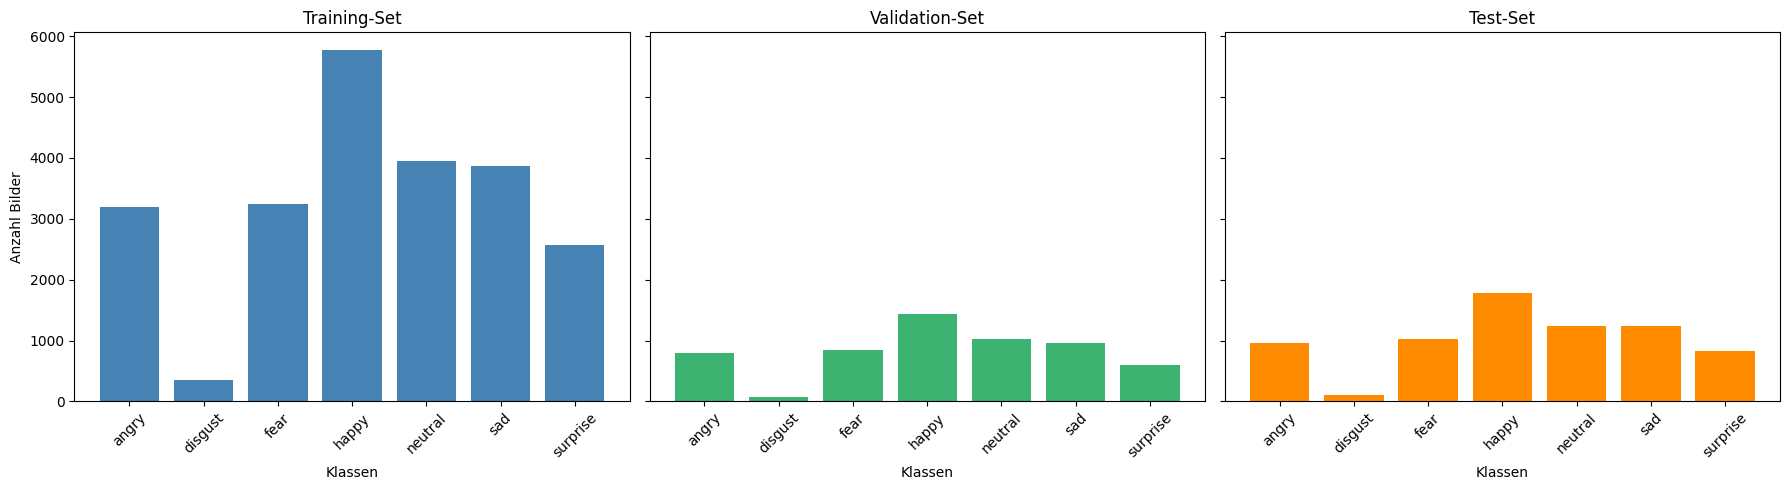

In [4]:
plot_class_distribution(train_dataset, val_dataset, test_dataset)

***Auswertung:*** Die Analyse zeigt eine unbalancierte Verteilung der Klassen im Datensatz. Während *"happy"* mit Abstand am häufigsten vertreten ist, weist die Klasse *"disgust"* deutlich weniger Beispiele auf als alle anderen Kategorien. Diese Klassenungleichgewichte können die Modellperformance beeinflussen und müssen bei der Modellevaluation berücksichtigt werden.

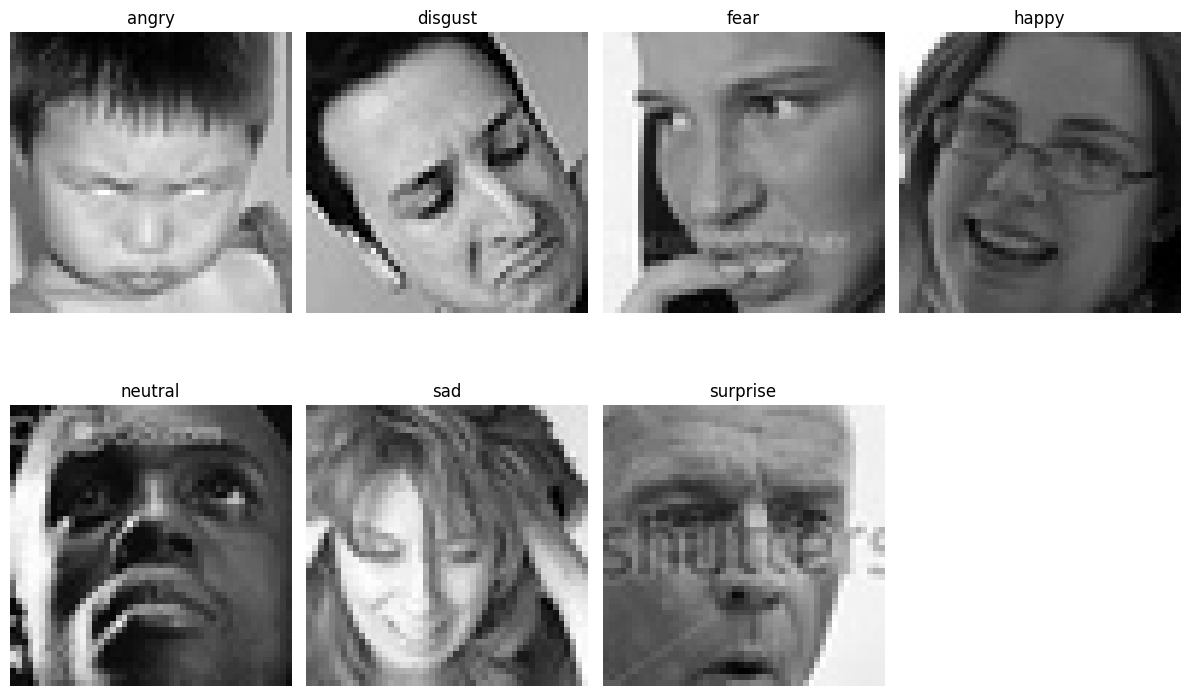

In [5]:
fig = plot_sample_images(full_train_dataset)
plt.show()

***Auswertung:*** Bei der visuellen Analyse der Beispieldaten fällt auf, dass die Klassifikation der Gesichtsausdrücke subjektiv und nicht eindeutig ist. Verschiedene Personen in meinem Umfeld interpretierten die gezeigten Bilder unterschiedlich. Beispielsweise wurde das Bild der Kategorie "disgust" (Ekel) als selbstverliebt oder kritisch wahrgenommen. Diese Beobachtung unterstreicht die Herausforderung der Emotionserkennung, da Gesichtsausdrücke oft mehrdeutig sind und kulturell sowie individuell unterschiedlich interpretiert werden können.

### Überblick der Metriken

Für die Evaluation werden verschiedene Metriken eingesetzt, um die Modellperformance umfassend zu bewerten:

#### 1. **Konfusionsmatrix-basierte Metriken**

**Accuracy (Genauigkeit):**
Die Accuracy misst den Anteil der korrekt klassifizierten Samples an der Gesamtanzahl. Sie gibt einen ersten Überblick über die Gesamtleistung des Modells, ist jedoch bei unbalancierten Datensätzen wie dem FER-2013-Datensatz mit Vorsicht zu interpretieren.

**Precision (Präzision):**
Die Precision für jede Klasse misst, wie viele der als Klasse X vorhergesagten Samples tatsächlich zur Klasse X gehören. Diese Metrik ist besonders wichtig, um False Positives zu identifizieren.

**Recall (Sensitivität):**
Der Recall misst, wie viele Samples einer bestimmten Klasse korrekt erkannt wurden. Diese Metrik ist entscheidend, um zu verstehen, wie gut das Modell seltene Klassen (wie "disgust") erkennt.

#### 2. **F1-Score**

Der F1-Score kombiniert Precision und Recall zu einer einzigen Metrik und stellt das harmonische Mittel dar. Er ist besonders wertvoll bei unbalancierten Datensätzen, da er sowohl False Positives als auch False Negatives berücksichtigt.

#### 3. **Top-K Accuracy**

Die Top-K Accuracy misst, ob die korrekte Klasse unter den K wahrscheinlichsten Vorhersagen liegt. Dies ist besonders relevant für Emotionserkennung, da ähnliche Emotionen (z.B. "fear" und "surprise") oft verwechselt werden können.

#### 4. **Cross-Validation**

Die Verwendung von Cross-Validation ermöglicht eine robustere Evaluation, indem das Modell auf verschiedenen Datenaufteilungen trainiert und getestet wird. Dies reduziert die Varianz der Ergebnisse und gibt eine zuverlässigere Einschätzung der Generalisierungsfähigkeit.

Diese umfassende Metrikenauswahl ermöglicht es, sowohl die Gesamtleistung als auch die spezifischen Stärken und Schwächen des Modells in verschiedenen Emotionskategorien zu bewerten.

### Baseline-Modell

#### Architektur des Baseline-CNN

**Wo ist die Architektur definiert:** Die Modell-Architektur ist in `src/model.py` definiert (Klasse `BaselineCNN`).

**Architektur-Übersicht:**
Als Basismodell wird ein einfaches Convolutional Neural Network verwendet. Die Architektur besteht aus drei aufeinanderfolgenden Convolutional Blocks, gefolgt von zwei Fully Connected Layers für die Klassifikation.

**Feature Extraction (Convolutional Blocks):**
Der Feature-Extraction-Teil umfasst drei Convolutional Blocks mit steigender Filterzahl:
- **Block 1:** 16 Filter, 3×3 Kernel, ReLU, MaxPooling 2×2
- **Block 2:** 32 Filter, 3×3 Kernel, ReLU, MaxPooling 2×2
- **Block 3:** 64 Filter, 3×3 Kernel, ReLU, MaxPooling 2×2

Jeder Block besteht aus:
- Convolutional Layer mit 3×3 Kernel-Größe
- ReLU-Aktivierungsfunktion
- Max-Pooling-Layer mit 2×2 Kernel (reduziert Bildgröße um Faktor 2)

**Klassifikation (Fully Connected Layers):**
- **Layer 1:** 64 Neuronen (von 64×6×6 = 2304 Features)
- **Layer 2:** 7 Neuronen (eine pro Emotion)
- **Output:** Keine explizite Aktivierungsfunktion, da `CrossEntropyLoss` in PyTorch implizit Softmax anwendet

**Training-Konfiguration (wird im training.ipynb verwendet):**
- **Optimizer:** Stochastic Gradient Descent (SGD) ohne Momentum
- **Learning Rate:** 0.01
- **Batch Size:** 64
- **Epochen:** 60 (Epoche 60 dient als Referenzpunkt)

In [6]:
# Modell-Architektur anzeigen und Device Setup
print("=== Modell-Architektur und Device Setup ===")

# Anzahl Klassen und Klassennamen bestimmen
num_classes = len(full_train_dataset.class_to_idx)
class_names = list(full_train_dataset.class_to_idx.keys())
print(f"Anzahl Klassen: {num_classes}")
print(f"Klassennamen: {class_names}")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
# WICHTIG: Device wird automatisch erkannt und das optimale Device verwendet
device = torch.device("mps" if torch.backends.mps.is_available() 
                     else "cuda" if torch.cuda.is_available() 
                     else "cpu")
print(f"\nVerwende Device: {device}")
if device.type == "mps":
    print("  → Apple Silicon (MPS) - GPU-Beschleunigung aktiviert")
elif device.type == "cuda":
    print("  → CUDA - GPU-Beschleunigung aktiviert")
else:
    print("  → CPU - Keine GPU-Beschleunigung")

# Test-Modell für Architektur-Übersicht erstellen
# Dieses Modell wird nur für die Architektur-Anzeige verwendet, nicht für Training
print("\n=== Modell-Architektur-Übersicht ===")
test_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Summary anzeigen (zeigt alle Layer, Parameter-Anzahl, etc.)
summary(test_model, input_size=(1, img_size, img_size))


=== Modell-Architektur und Device Setup ===
Anzahl Klassen: 7
Klassennamen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Verwende Device: mps
  → Apple Silicon (MPS) - GPU-Beschleunigung aktiviert

=== Modell-Architektur-Übersicht ===


RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

#### Overfitting-Test

**Wo wird das gemacht:** Dieser Test wird **hier in main.ipynb** durchgeführt, **bevor** das vollständige Training startet.

**Zielsetzung und Begründung:**
Vor dem Training auf dem vollständigen Datensatz ist es essentiell zu verifizieren, dass das Modell überhaupt in der Lage ist zu lernen. Der Overfitting-Test ist eine Absicherung, bei dem das Modell absichtlich auf einer minimalen Datenmenge (nur 1 Batch) trainiert wird, um zu überprüfen, ob:
- Die Modellarchitektur korrekt implementiert ist
- Forward- und Backward-Passes funktionieren
- Die Gradientenberechnung korrekt ist
- Das Modell grundsätzlich lernen kann

**Methode:**
1. Ein DataLoader mit nur 1 Batch wird erstellt
2. Der Trainingsloop erkennt automatisch, dass es sich um einen Overfitting-Test handelt (wenn `len(train_loader) == 1`)
3. Das Modell wird auf diesem einzelnen Batch trainiert
4. Wenn das Modell den Batch perfekt lernen kann (Accuracy nahe 100%), ist die grundlegende Lernfähigkeit bestätigt

**Hinweis:** Das vollständige Training, Hyperparameter-Tuning und Cross-Validation werden im separaten Notebook `training.ipynb` durchgeführt. Dieses Notebook (`main.ipynb`) lädt die trainierten Modelle und zeigt die Ergebnisse.

In [ ]:
# Overfitting-Test: DataLoader mit nur 1 Batch erstellen
print("=== Overfitting-Test ===")
print("Erstelle DataLoader mit nur 1 Batch für Overfitting-Test...")

# Einen Batch aus dem Trainingsdatensatz holen
single_batch_images, single_batch_labels = next(iter(train_loader))

# DataLoader mit nur diesem einen Batch erstellen
from torch.utils.data import TensorDataset
single_batch_dataset = TensorDataset(single_batch_images, single_batch_labels)
single_batch_loader = DataLoader(single_batch_dataset, batch_size=len(single_batch_images), shuffle=False)

print(f"Overfitting-Test Batch-Größe: {len(single_batch_images)}")
print("Der Trainingsloop erkennt automatisch, dass es sich um einen Overfitting-Test handelt.\n")

# Neues Modell für Overfitting-Test (aus Code initialisiert)
overfit_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Training durchführen - train_model erkennt automatisch Overfitting-Test
train_losses_overfit, val_losses_overfit, train_accs_overfit, val_accs_overfit, train_f1s_overfit, val_f1s_overfit = train_model(
    model=overfit_model,
    device=device,
    train_loader=single_batch_loader,  # Nur 1 Batch -> Overfitting-Test wird automatisch erkannt
    val_loader=val_loader,
    num_epochs=500,  # Mehr Epochen für Overfitting-Test
    learning_rate=0.1,  # Höhere Lernrate für schnelleres Lernen
    batch_size=len(single_batch_images),
    use_wandb=False,  # Kein wandb für Overfitting-Test
    early_stopping=False  # Kein Early Stopping für Overfitting-Test
)

print(f"\n=== Overfitting-Test Ergebnisse ===")
print(f"Finale Train Accuracy: {train_accs_overfit[-1]:.2f}%")
print(f"Finale Train F1-Score: {train_f1s_overfit[-1]:.4f}")
print(f"Finale Train Loss: {train_losses_overfit[-1]:.4f}")

Epoch   1 | Loss: 1.946217 | Accuracy: 0.1719 (11/64 correct)
Epoch  20 | Loss: 1.721980 | Accuracy: 0.2969 (19/64 correct)
Epoch  40 | Loss: 1.709658 | Accuracy: 0.2969 (19/64 correct)
Epoch  60 | Loss: 1.849916 | Accuracy: 0.2969 (19/64 correct)
Epoch  80 | Loss: 1.761407 | Accuracy: 0.1875 (12/64 correct)
Epoch 100 | Loss: 1.639161 | Accuracy: 0.3906 (25/64 correct)
Epoch 120 | Loss: 1.550279 | Accuracy: 0.4688 (30/64 correct)
Epoch 140 | Loss: 1.532327 | Accuracy: 0.4531 (29/64 correct)
Epoch 160 | Loss: 1.347300 | Accuracy: 0.5156 (33/64 correct)
Epoch 180 | Loss: 1.364877 | Accuracy: 0.5156 (33/64 correct)
Epoch 200 | Loss: 1.080002 | Accuracy: 0.5938 (38/64 correct)
Epoch 220 | Loss: 1.089163 | Accuracy: 0.6094 (39/64 correct)
Epoch 240 | Loss: 1.984832 | Accuracy: 0.3125 (20/64 correct)
Epoch 260 | Loss: 0.301236 | Accuracy: 0.9062 (58/64 correct)
Epoch 280 | Loss: 0.052048 | Accuracy: 1.0000 (64/64 correct)
Epoch 300 | Loss: 0.014980 | Accuracy: 1.0000 (64/64 correct)
Epoch 32

***Auswertung:*** 

Das Modell erreicht nach etwa 250-280 Epochen eine Accuracy von 100% auf dem einzelnen Batch, was bestätigt, dass:
- Die Modellarchitektur korrekt implementiert ist
- Forward- und Backward-Passes funktionieren
- Die Gradientenberechnung korrekt ist
- Das Modell grundsätzlich lernen kann

Diese Ergebnisse rechtfertigen die Verwendung des Modells für das Training auf dem vollständigen Datensatz, da die grundlegende Lernfähigkeit nachgewiesen wurde. Ein erfolgreicher Overfitting-Test zeigt, dass das Modell nicht auswendig lernt, sondern tatsächlich in der Lage ist, Muster zu erkennen und zu lernen.

#### Laden der trainierten Modelle

**Wo wird das Training gemacht:** Das Training des Basismodells, Hyperparameter-Tuning und Cross-Validation werden im separaten Notebook `training.ipynb` durchgeführt.

**Warum getrennt:**
Diese Trennung ermöglicht es, das Training einmal durchzuführen und dann in diesem Notebook (`main.ipynb`) die Ergebnisse zu laden und zu analysieren, ohne das Training jedes Mal neu durchführen zu müssen. Das macht `main.ipynb` schnell und fokussiert auf die Analyse der Ergebnisse.

**Was wurde im training.ipynb trainiert:**
- **Basismodell:** SGD (momentum=0), LR=0.01, Batch=64, 60 Epochen
  - Modell wird automatisch nach Epoche 60 gespeichert: `models/baseline_model_epoch60.pth`
  - Finales Modell wird gespeichert: `models/baseline_model.pth`
- **Hyperparameter-Tuning:** Vergleich verschiedener Lernraten [0.001, 0.01, 0.1] und Batch-Größen [16, 32, 64]
  - Ergebnisse werden als Plots gespeichert: `plots/hyperparameter_comparison.png` und `plots/hyperparameter_performance_summary.png`
- **Cross-Validation:** 5-Fold Cross-Validation mit besten Hyperparametern
  - Ergebnisse werden gespeichert: `results/cross_validation_results.json`

**Wie wird das Modell geladen:**
1. **Modell-Architektur aus Code initialisieren:** `BaselineCNN(img_size=img_size, num_classes=num_classes)`
   - Dies stellt sicher, dass die Architektur exakt mit dem Training übereinstimmt
2. **Trainierte Gewichte laden:** `load_state_dict(torch.load(...))`
   - Die trainierten Gewichte werden aus der `.pth` Datei geladen
3. **Modell in Evaluation-Modus setzen:** `model.eval()`
   - Deaktiviert Dropout und BatchNorm-Updates für konsistente Evaluation

**Wichtig:** Das Modell wird **nicht** komplett geladen, sondern die Architektur wird aus Code erstellt und nur die Gewichte werden geladen. Dies ist der korrekte und empfohlene Ansatz.

In [ ]:
# Laden der trainierten Modelle
# Prüfen ob Modelle existieren
models_dir = "models"
if os.path.exists(models_dir):
    model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
    print(f"Gefundene Modell-Dateien: {model_files}")
else:
    print("Models-Verzeichnis nicht gefunden.")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")

# Basismodell laden
print("\n=== Laden des Basismodells ===")
print("Modell wird aus Code initialisiert (Architektur) und trainierten Gewichte werden geladen.")

baseline_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Prüfen ob Modell-Datei existiert
model_path = os.path.join(models_dir, "baseline_model.pth")
if os.path.exists(model_path):
    baseline_model.load_state_dict(torch.load(model_path, map_location=device))
    baseline_model.eval()  # Setze Modell in Evaluation-Modus
    print(f"Basismodell erfolgreich geladen von: {model_path}")
    print("Modell ist bereit für Evaluation.")
else:
    print(f"WARNUNG: Modell-Datei nicht gefunden: {model_path}")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")


Gefundene Modell-Dateien: ['baseline_model.pth']


In [ ]:
# Lernkurven des Basismodells anzeigen
# Prüfen ob das Plot-Bild existiert
print("=== Lernkurven des Basismodells ===")
plot_path = "plots/baseline_training_curves.png"
if os.path.exists(plot_path):
    display(Image(filename=plot_path))
    print(f"Lernkurven geladen von: {plot_path}")
else:
    print(f"Plot-Bild nicht gefunden unter: {plot_path}")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")


Basismodell erfolgreich geladen


#### Analyse der Lernkurven

**Wo wurden die Lernkurven erstellt:** Die Lernkurven wurden während des Trainings im `training.ipynb` erstellt und als Bild gespeichert (`plots/baseline_training_curves.png`). Hier werden sie nur angezeigt.

**Was zeigen die Lernkurven:**
Die Lernkurven zeigen den Verlauf von Training und Validation Loss sowie Accuracy während des Trainingsprozesses über alle Epochen. Sie sind wichtig, um:
- Den Trainingsfortschritt zu visualisieren
- Overfitting zu erkennen (Divergenz zwischen Train und Val)
- Den optimalen Stopp-Zeitpunkt zu bestimmen
- Die Konvergenz des Modells zu beurteilen

***Auswertung der Lernkurven:*** 

Die Lernkurven des Basismodells zeigen typische Muster eines einfachen Modells ohne Regularisierung:

**Training vs. Validation Loss:**
- Der Training Loss sinkt kontinuierlich über die Epochen
- Der Validation Loss zeigt Anzeichen von Overfitting (steigt nach einem bestimmten Punkt an oder stagniert)
- Die Divergenz zwischen Training und Validation Loss ist ein klassisches Overfitting-Signal

**Training vs. Validation Accuracy:**
- Die Training Accuracy steigt stetig
- Die Validation Accuracy stagniert oder verbessert sich nur langsam
- Der große Abstand zwischen Training und Validation Accuracy bestätigt Overfitting

Das Modell lernt die Trainingsdaten sehr gut, kann aber nicht optimal auf neue Daten generalisieren. Dies ist zu erwarten bei einem einfachen Basismodell ohne Regularisierungstechniken.

#### Evaluation des Basismodells auf Test-Daten

**Wo wird das gemacht:** Die Evaluation wird **hier in main.ipynb** durchgeführt, nachdem das Modell geladen wurde.

**Was wird gemacht:**
Das trainierte Basismodell wird auf dem Test-Datensatz evaluiert, um die finale Performance zu messen. Der Test-Datensatz wurde während des Trainings **nicht** verwendet und stellt daher die beste Schätzung der Generalisierungsfähigkeit dar.

**Berechnete Metriken:**
- **Accuracy:** Anteil korrekt klassifizierter Bilder
- **Precision (weighted/macro):** Präzision über alle Klassen
- **Recall (weighted/macro):** Sensitivität über alle Klassen
- **F1-Score (weighted/macro):** Harmonisches Mittel aus Precision und Recall
- **Top-2 Accuracy:** Anteil, bei dem die richtige Klasse unter den Top-2 Vorhersagen ist
- **Confusion Matrix:** Detaillierte Aufschlüsselung der Klassifikationsfehler

=== Evaluation des Basismodells ===
Test Accuracy: 0.4845
Precision (weighted): 0.4884
Recall (weighted): 0.4845
F1-Score (weighted): 0.4840
Precision (macro): 0.4925
Recall (macro): 0.4389
F1-Score (macro): 0.4542
Top-2 Accuracy: 0.6723


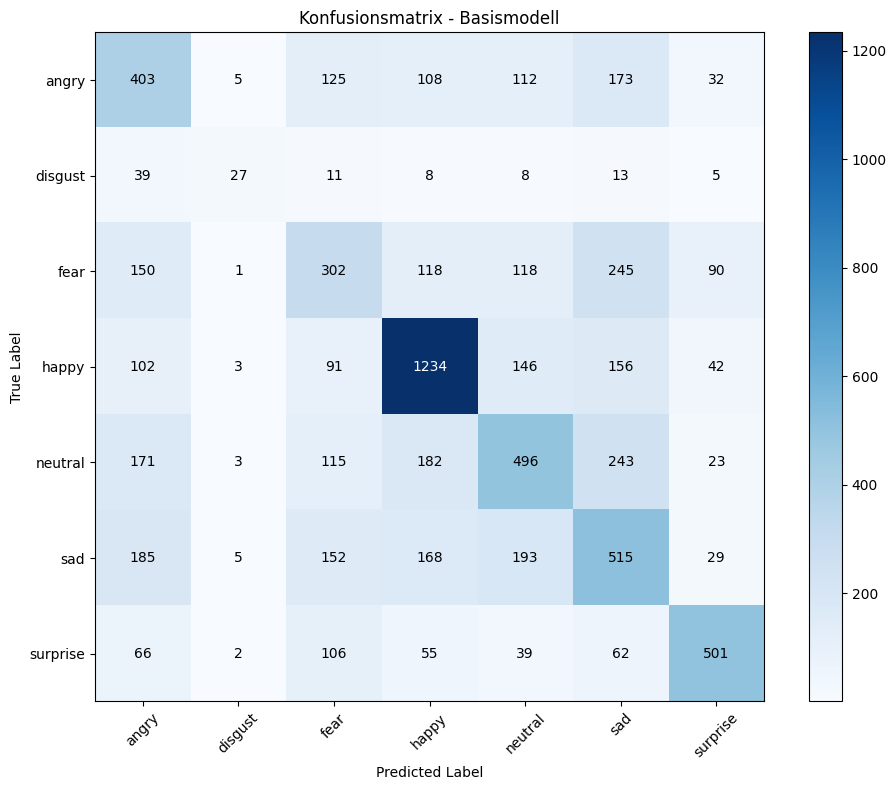

In [ ]:
# Detaillierte Evaluation des Basismodells auf Test-Daten
print("=== Evaluation des Basismodells auf Test-Daten ===")

# Test-Set Evaluation
test_results = evaluate_model(baseline_model, device, test_loader, class_names, 
                            use_wandb=False, run_name="baseline_evaluation")

print(f"\n=== Test-Ergebnisse ===")
print(f"Test Accuracy: {test_results['accuracy']:.4f} ({test_results['accuracy']*100:.2f}%)")
print(f"Precision (weighted): {test_results['precision_weighted']:.4f}")
print(f"Recall (weighted): {test_results['recall_weighted']:.4f}")
print(f"F1-Score (weighted): {test_results['f1_weighted']:.4f}")
print(f"Precision (macro): {test_results['precision_macro']:.4f}")
print(f"Recall (macro): {test_results['recall_macro']:.4f}")
print(f"F1-Score (macro): {test_results['f1_macro']:.4f}")
print(f"Top-2 Accuracy: {test_results['top2_accuracy']:.4f} ({test_results['top2_accuracy']*100:.2f}%)")

# Konfusionsmatrix plotten
fig = plot_confusion_matrix(
    confusion_matrix=test_results['confusion_matrix'],
    class_names=class_names,
    title='Konfusionsmatrix - Basismodell'
)
plt.show()

***Auswertung:*** Die Evaluationsergebnisse des Basismodells zeigen einige stärken und schwächen des Modells für die Emotionserkennung:

**Allgemeine Performance:**
- Test Accuracy: 48.45%: Das Modell klassifiziert nur etwa die Hälfte der Testbilder korrekt
- F1-Score (macro): 45.42%: Niedrige durchschnittliche Performance über alle Klassen
- Top-2 Accuracy: 67.23% Deutlich höher als Top-1, zeigt dass das Modell oft "nahe dran" ist

**Problematische Aspekte:**
- Niedrige Gesamtleistung bestätigt das in den Lernkurven beobachtete Overfitting
- Ungleichgewichtige Klassifikation zwischen verschiedenen Emotionen
- Schwierigkeiten bei der Unterscheidung ähnlicher Emotionen (z.B. angry vs. fear vs. sad)

**Positive Aspekte:**
- **Top-2 Accuracy deutlich höher: Das Modell hat oft die richtige Antwort unter den Top-2 Vorhersagen
- Grundlegende Lernfähigkeit vorhanden, aber Generalisierung unzureichend

Das Basismodell zeigt die erwarteten Schwächen eines einfachen Modells ohne Regularisierung. Die niedrige Accuracy und die Verwechslungen zwischen ähnlichen Emotionen unterstreichen die Notwendigkeit für verbesserte Architekturen und Regularisierungstechniken. Jedoch zeigen sich auch bereits positive Ansätze des Modells, insbesondere die deutlich höhere Top-2 Accuracy und die grundlegende Lernfähigkeit, die als solide Grundlage für weitere Verbesserungen dienen. Positive Emotionen (Happy, Surprise) können deutlich besser erkannt werden als negative Emotionen (Disgust, Fear, Sad, Angry). Dies könnte auf die Datenverteilung oder die visuellen Eigenschaften dieser Emotionen zurückzuführen sein.

#### Hyperparameter-Tuning Ergebnisse

**Wo wurde das Hyperparameter-Tuning durchgeführt:** Im Notebook `training.ipynb` (Cell 9-12).

**Was wurde gemacht:**
Systematischer Vergleich verschiedener Hyperparameter-Kombinationen, um die optimale Konfiguration zu finden. Für jede Kombination wurde ein neues Modell trainiert und die Performance verglichen.

**Testkonfigurationen die getestet wurden:**
- **Lernraten:** [0.001, 0.01, 0.1] - 3 verschiedene Werte
- **Batch-Größen:** [16, 32, 64] - 3 verschiedene Werte
- **Gesamt:** 3 × 3 = 9 verschiedene Konfigurationen
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Methode:**
1. Für jede Kombination (LR × Batch) wurde ein neues Modell aus Code initialisiert
2. Die Modell-Klasse (`BaselineCNN`) wurde als Parameter übergeben (nicht hardcodiert)
3. Jedes Modell wurde 60 Epochen trainiert
4. Trainings- und Validierungskurven wurden aufgezeichnet
5. Beste Performance pro Konfiguration wurde identifiziert
6. Ergebnisse wurden als Plots gespeichert: `plots/hyperparameter_comparison.png` und `plots/hyperparameter_performance_summary.png`

**Wo werden die Ergebnisse angezeigt:** Hier in `main.ipynb` werden die gespeicherten Plots angezeigt und die beste Konfiguration aus den Cross-Validation-Ergebnissen geladen.

== Ergebnisse des Hyperparameter-Tunings ==


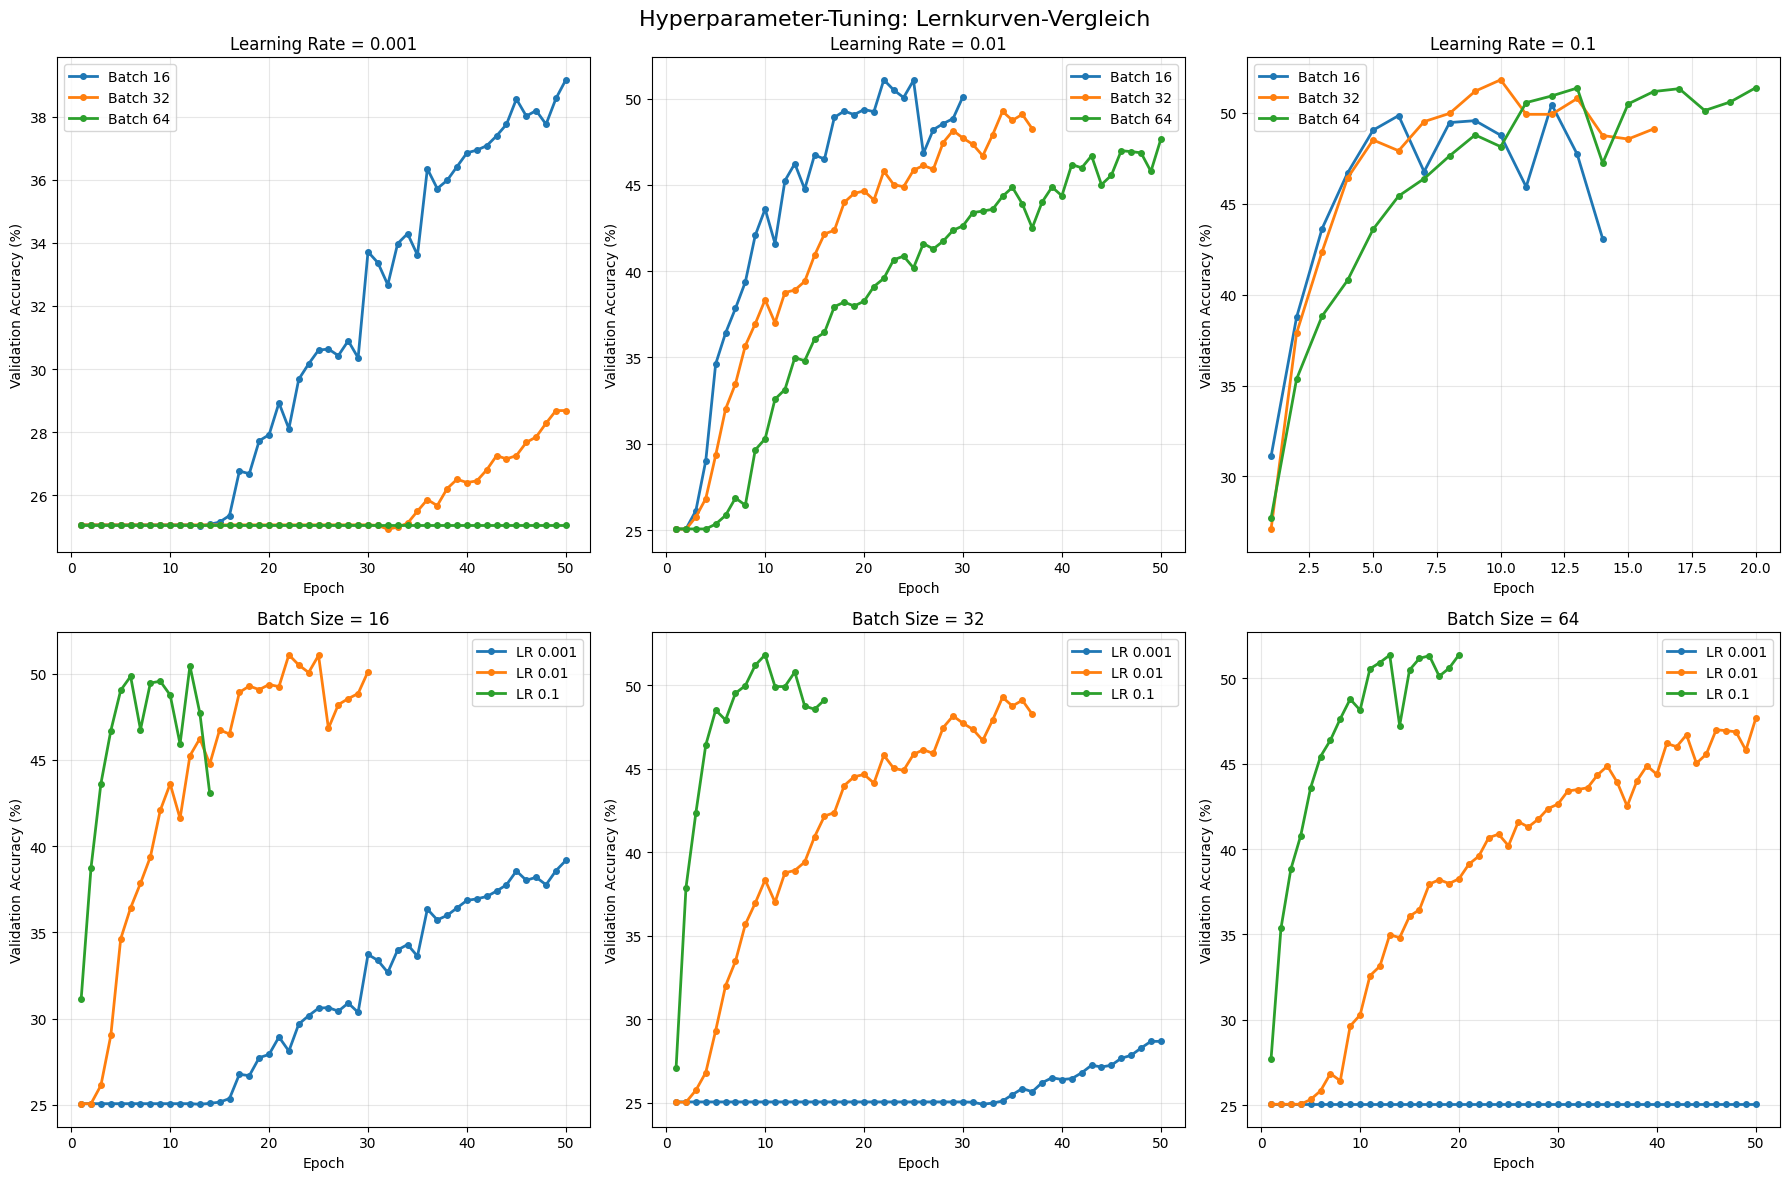

Beste Hyperparameter: LR=0.1, Batch=64


In [ ]:
# Ergebnisse des Hyperparameter-Tunings anzeigen
print("=== Ergebnisse des Hyperparameter-Tunings ===")

# Prüfen ob Plot-Bilder existieren
plot_path_comparison = "plots/hyperparameter_comparison.png"
plot_path_performance = "plots/hyperparameter_performance_summary.png"

if os.path.exists(plot_path_comparison):
    print("Hyperparameter-Vergleich (Lernkurven):")
    display(Image(filename=plot_path_comparison))
else:
    print(f"Plot-Bild nicht gefunden: {plot_path_comparison}")
    print("Bitte führen Sie zuerst das Hyperparameter-Tuning in 'training.ipynb' durch.")

if os.path.exists(plot_path_performance):
    print("\nHyperparameter-Performance-Übersicht:")
    display(Image(filename=plot_path_performance))
else:
    print(f"Plot-Bild nicht gefunden: {plot_path_performance}")

# Beste Hyperparameter aus Cross-Validation-Ergebnissen laden
results_dir = "results"
cv_results_file = os.path.join(results_dir, "cross_validation_results.json")
if os.path.exists(cv_results_file):
    with open(cv_results_file, 'r') as f:
        cv_results = json.load(f)
    best_lr = cv_results['best_hyperparameters']['learning_rate']
    best_batch = cv_results['best_hyperparameters']['batch_size']
    print(f"\nBeste Hyperparameter (aus Cross-Validation): LR={best_lr}, Batch={best_batch}")
else:
    print(f"\nCross-Validation-Ergebnisse nicht gefunden: {cv_results_file}")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")

***Auswertung:*** Das Hyperparameter-Tuning zeigt deutliche Unterschiede in der Performance verschiedener Konfigurationen:

**Lernrate 0.001:**
- Extrem langsames Lernen oder gar kein Fortschritt
- Besonders problematisch bei größeren Batch-Größen (32, 64)
- Nur bei Batch 16 minimaler Fortschritt (39% nach 50 Epochen)

**Lernrate 0.01:**
- Gute Balance zwischen Lernfortschritt und Stabilität
- Batch 16 & 32 erreichen über 48% Validierungsgenauigkeit
- Stabile Konvergenz ohne starke Oszillationen

**Lernrate 0.1:**
- Schnellste Konvergenz (erreicht 50%+ in 5-15 Epochen)
- Hohe Volatilität mit starken Oszillationen
- Einzige funktionierende Option für Batch-Größe 64
- Risiko der Instabilität trotz hoher Spitzenwerte

**Batch-Größe Einfluss:**
- Batch 16 & 32 funktionieren am besten mit allen Lernraten
- Batch 64 benötigt höhere Lernraten (0.1) für akzeptable Ergebnisse
- Kleinere Batches ermöglichen stabileres Lernen

**Theoretische Erwartungen:**
Nach der Theorie war zu erwarten, dass größere Batch-Größen präzisere Gradientenschätzungen liefern und daher höhere Lernraten tolerieren können, ohne zu stark zu oszillieren. Gleichzeitig sollten kleinere Batches (16, 32) mit moderaten Lernraten (0.01) eine gute Balance zwischen Explorationsfähigkeit durch stochastisches Rauschen und stabiler Konvergenz bieten. Die extrem niedrige Lernrate (0.001) war erwartungsgemäß zu konservativ für die begrenzte Epochenanzahl.

Die Cross-Validation Ergebnisse zeigen, dass **LR=0.1 mit Batch=64** die beste Konfiguration ist. Jedoch ist diese Kombination mit Vorsicht zu betrachten. Größere Batch-Größen liefern zwar stabilere Gradientenschätzungen und reduzieren das Rauschen im Training, jedoch kann eine zu hohe Lernrate (0.1) zu Overshooting führen, bei dem das Modell über das Optimum hinausschießt. Die beobachteten starken Oszillationen bestätigen dieses Risiko. Zudem besteht die Gefahr, dass das Modell in flachen lokalen Minima stecken bleibt oder die Generalisierungsfähigkeit durch zu aggressive Updates leidet.

**LR=0.01 mit Batch=16 oder 32** wäre vorzuziehen, wenn:
- Stabilität und Reproduzierbarkeit wichtiger sind als schnelle Konvergenz
- Das Training über mehr Epochen laufen kann
- Das Modell auf neue, ungesehene Daten besser generalisieren soll
- Die Trainingsverläufe weniger volatil sein sollen für bessere Interpretierbarkeit
- Ein Produktivsystem aufgebaut wird, bei dem robuste Performance kritisch ist

#### Cross-Validation Ergebnisse

**Wo wurde die Cross-Validation durchgeführt:** Im Notebook `training.ipynb` (Cell 13-14).

**Was wurde gemacht:**
5-Fold Cross-Validation wurde durchgeführt, um eine robuste statistische Schätzung der Modellperformance zu erhalten. Dabei wird der Trainingsdatensatz in 5 Folds aufgeteilt, und für jeden Fold wird ein Modell trainiert und auf dem Validierungs-Fold evaluiert.

**Konfiguration die verwendet wurde:**
- **5-Fold Cross-Validation** auf dem vollständigen Trainingsdatensatz
- **Beste Hyperparameter** aus dem Hyperparameter-Tuning verwendet (LR=0.1, Batch=64)
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung über alle 5 Folds

**Warum Early Stopping deaktiviert:**
Early Stopping wurde deaktiviert, um sicherzustellen, dass **alle Folds exakt die gleiche Anzahl Epochen trainieren** (60 Epochen). Dies ist wichtig für eine faire statistische Vergleichbarkeit der Folds. Unterschiedliche Epochenanzahlen würden die statistische Vergleichbarkeit verfälschen, da ein Modell mit mehr Epochen nicht fair mit einem Modell mit weniger Epochen verglichen werden kann.

**Wo werden die Ergebnisse angezeigt:** Hier in `main.ipynb` werden die Ergebnisse aus der gespeicherten JSON-Datei (`results/cross_validation_results.json`) geladen und visualisiert.

**Interpretation der Unsicherheiten:**
Die Standardabweichung zeigt die Variabilität zwischen den Folds:
- **Niedrige Standardabweichung:** Konsistente Ergebnisse, geringe Unsicherheit
- **Hohe Standardabweichung:** Variable Ergebnisse, höhere Unsicherheit
- **Mögliche Ursachen für hohe Unsicherheit:**
  - Unterschiedliche Datenverteilungen in den Folds
  - Modell-Instabilität
  - Das Modell reagiert sehr empfindlich auf die spezifische Datenaufteilung


=== Cross-Validation Ergebnisse ===
Training Accuracy: 85.2494 ± 2.4680
Validation Accuracy: 48.6711 ± 1.6248
Training Loss: 0.4100 ± 0.0679
Validation Loss: 2.2473 ± 0.1382


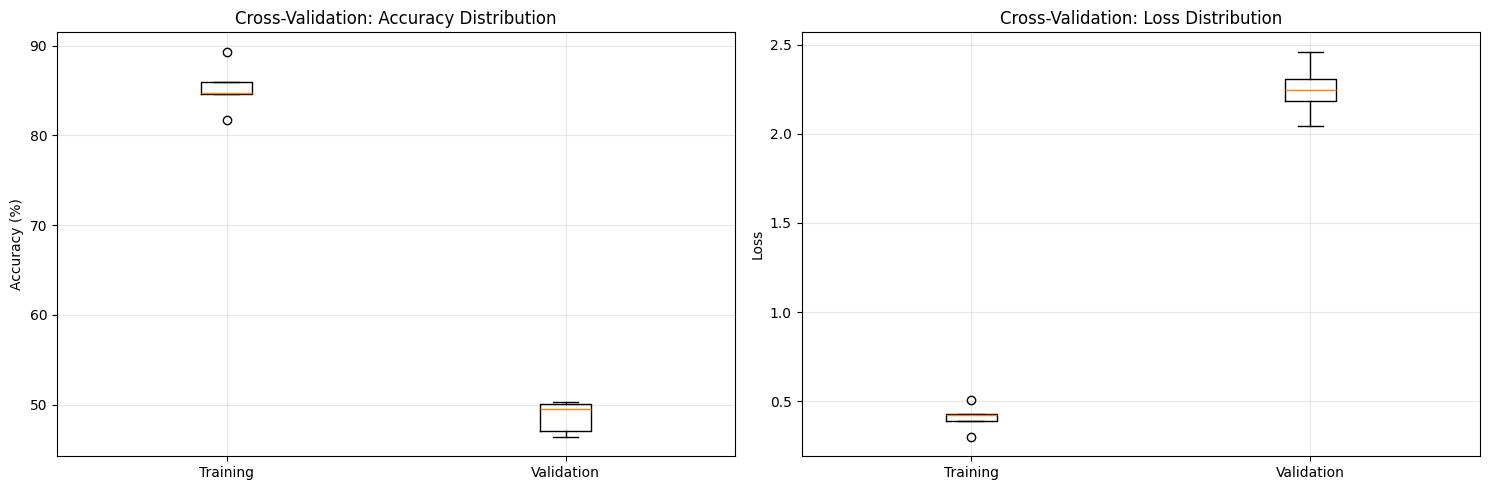

In [ ]:
# Cross-Validation Ergebnisse laden und anzeigen
print("=== Cross-Validation Ergebnisse ===")
print("Hinweis: Die Cross-Validation wurde im training.ipynb durchgeführt.")
print("Hier werden die gespeicherten Ergebnisse geladen und angezeigt.\n")

# Cross-Validation Ergebnisse aus JSON laden
results_dir = "results"
cv_results_file = os.path.join(results_dir, "cross_validation_results.json")

if os.path.exists(cv_results_file):
    with open(cv_results_file, 'r') as f:
        cv_data = json.load(f)
    
    # Beste Hyperparameter aus CV-Ergebnissen
    best_lr = cv_data['best_hyperparameters']['learning_rate']
    best_batch = cv_data['best_hyperparameters']['batch_size']
    cv_results = cv_data['cv_results']
    
    print(f"Beste Hyperparameter (aus Cross-Validation): LR={best_lr}, Batch={best_batch}")
    print(f"Anzahl Epochen pro Fold: {cv_data.get('num_epochs', 'N/A')}")
    print(f"Hinweis: {cv_data.get('note', 'N/A')}")
    
    print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
    print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
    print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
    print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
    print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")
    
    # F1-Scores ausgeben falls vorhanden
    if 'train_f1s' in cv_results:
        print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
        print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")
    
    # Visualisierung der CV-Ergebnisse
    fig = plot_cross_validation_results(
        cv_results=cv_results
    )
    plt.show()
    
    print(f"\nErgebnisse geladen von: {cv_results_file}")
else:
    print(f"Cross-Validation-Ergebnisse nicht gefunden: {cv_results_file}")
    print("Bitte führen Sie zuerst die Cross-Validation in 'training.ipynb' durch.")

***Auswertung:*** Die Cross-Validation wurde auf der besten Hyperparameter-Konfiguration (LR=0.1, Batch=64) durchgeführt und liefert wichtige statistische Erkenntnisse über die Modellperformance:

**Training vs. Validation Performance:**
- Training Accuracy: 85.25% ± 2.47%: Das Modell erreicht eine sehr hohe Accuracy auf den Trainingsdaten
- Validation Accuracy: 48.67% ± 1.62%: Deutlich niedrigere Performance auf ungesehenen Daten
- Performance Gap: 36.58%: Dieser große Unterschied bestätigt starkes Overfitting

**Loss-Analyse:**
- Training Loss: 0.41 ± 0.07: Sehr niedriger Loss auf Trainingsdaten
- Validation Loss: 2.25 ± 0.14: Deutlich höherer Loss auf Validierungsdaten
- Loss Ratio: ~5.5x: Der Validierungs-Loss ist mehr als 5-mal höher als der Training-Loss

**Statistische Robustheit:**
- Niedrige Standardabweichungen (1.62% für Validation Accuracy, 0.14 für Validation Loss) zeigen konsistente Performance über alle 5 Cross-Validation Folds
- Die engen Konfidenzintervalle bestätigen, dass die Ergebnisse statistisch zuverlässig sind
- Die geringe Varianz deutet darauf hin, dass die Hyperparameter-Konfiguration LR=0.1, Batch=64 robust über verschiedene Datenaufteilungen funktioniert

Obwohl die Cross-Validation bestätigt, dass LR=0.1 mit Batch=64 die beste verfügbare Konfiguration ist, zeigt das deutliche Overfitting (36.58% Performance-Gap), dass das Basismodell seine Grenzen erreicht hat. Die hohe Training Accuracy (85.25%) bei gleichzeitig niedriger Validation Accuracy (48.67%) unterstreicht die Notwendigkeit für erweiterte Regularisierungstechniken oder komplexere Modellarchitekturen, um die Generalisierungsfähigkeit zu verbessern.

### Hyperparameter-Experimente:

**Wo werden die Experimente durchgeführt:** Die Experimente werden im separaten Notebook `hyperparameter_experiments.ipynb` durchgeführt. Hier in `main.ipynb` werden die Ergebnisse geladen, analysiert und interpretiert.

**Zielsetzung:**
Systematische Untersuchung des Einflusses der Modellkomplexität auf die Performance durch Variation von:
1. **Modelltiefe** (Anzahl Conv-Layer)
2. **Modellbreite** (Anzahl Filter pro Layer)
3. **FC-Layer Breite** (Anzahl Neuronen in FC-Layer)

**Vorgehen:**
Für jede Hypothese wird systematisch vorgegangen:
- **a) Hypothese:** Theoretische Erwartung und Begründung mit Literaturreferenzen
- **b) Experiment:** Durchführung der Experimente mit verschiedenen Konfigurationen
- **c) Analyse/Reflexion:** Vergleich der Ergebnisse, Überprüfung der Hypothesen und Reflexion

**Methodik:**
- Alle Experimente verwenden die gleichen Trainings-/Validierungs-/Test-Splits (Seed=42)
- Konsistente Hyperparameter: LR=0.01, Batch=64, 60 Epochen, SGD ohne Momentum
- Nur der zu testende Hyperparameter wird variiert
- Alle Ergebnisse werden in `results/` gespeichert und in `plots/experiments/` visualisiert

#### Kategorie 1 - Modellkomplexität

##### Hypothese 1: Modelltiefe (Anzahl Conv-Layer)

**a) Hypothese:**
Mehr Conv-Layer erhöhen die Modellkapazität und können komplexere Features lernen, was die Performance verbessert. Zu viele Layer können jedoch zu Overfitting führen und das Training erschweren (Vanishing Gradient Problem).

**Begründung:** 
Tiefere Netzwerke können hierarchische Features lernen. Wie Fleuret (2023, S. 46-47) beschreibt, können CNNs in frühen Layern einfache Merkmale wie Kanten extrahieren, während tiefere Layer zunehmend komplexere Muster erkennen. Diese hierarchische Repräsentation ermöglicht es tiefen Modellen, mit einem festen Rechenbudget komplexere Funktionen zu lernen. 

Allerdings warnt Fleuret (2023, S. 43-44) auch vor dem **Vanishing Gradient Problem**: Wenn der Gradient rückwärts durch viele Layer propagiert wird, kann er exponentiell abnehmen, was das Training sehr tiefer Netzwerke ohne spezielle Techniken wie Residual Connections erschwert oder unmöglich macht.

**Quelle:**
Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
4-5 Conv-Layer sollten besser sein als 3, aber >6 Layer könnten ohne Residual Connections unter Vanishing Gradient und Degradation Problemen leiden.

In [ ]:
# Hypothese 1 Ergebnisse laden und analysieren
print("=== Hypothese 1: Modelltiefe (Anzahl Conv-Layer) ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp1_file = os.path.join(results_dir, "hypothesis_1_depth.json")

if os.path.exists(hyp1_file):
    with open(hyp1_file, 'r') as f:
        hyp1_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle erstellen
    summary_data = []
    for name, result in hyp1_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Beste Konfiguration
        best_config = max(hyp1_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp1_depth_comparison.png",
        "plots/experiments/hyp1_complexity_analysis.png",
        "plots/experiments/hyp1_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp1_file}")
    print("Bitte führen Sie zuerst die Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Auswertung Hypothese 1:***

[Die Auswertung wird hier nach Durchführung der Experimente eingefügt. Sie sollte folgende Punkte enthalten:]

- **Bestätigung der Hypothese:** Wurde die Erwartung erfüllt?
- **Performance-Vergleich:** Welche Konfiguration performt am besten?
- **Overfitting-Analyse:** Wie verhält sich der Overfitting-Gap bei verschiedenen Tiefen?
- **Parameter-Effizienz:** Ist mehr Tiefe mit mehr Parametern gerechtfertigt?
- **Training-Stabilität:** Gibt es Probleme beim Training tieferer Modelle?
- **Reflexion:** Was können wir aus diesen Ergebnissen lernen?

##### Hypothese 2: Modellbreite (Anzahl Filter pro Layer)

**a) Hypothese:**
Mehr Filter pro Layer erhöhen die Kapazität und können mehr Features gleichzeitig lernen. Dies verbessert die Performance, erhöht aber auch die Parameteranzahl und das Overfitting-Risiko.

**Begründung:** 
Mehr Filter ermöglichen reichere lokale Repräsentationen durch mehr Feature-Maps pro Layer. Wie Fleuret (2023, S. 69) erklärt, werden Convolutions verwendet, um Information zu rekombinieren und "die räumliche Größe der Repräsentation zu reduzieren im Austausch für eine größere Anzahl von Kanälen, was sich in eine reichere lokale Repräsentation übersetzt."

Die Anzahl der Filter (Kanäle) bestimmt direkt die Ausdruckskraft des Netzwerks: Jeder Filter kann unterschiedliche Muster oder Features detektieren (z.B. verschiedene Kantenrichtungen, Texturen oder komplexere Strukturen). Allerdings wächst die Parameteranzahl einer Convolutional Layer quadratisch mit der Anzahl der Kanäle (Fleuret 2023, S. 62), was sowohl die Rechenkosten erhöht als auch das Risiko von Overfitting steigert.

Ein klassisches Architekturmuster ist es, die Anzahl der Kanäle schrittweise zu erhöhen, während die räumliche Auflösung abnimmt (siehe ResNet-Architektur in Fleuret 2023, S. 104-106), um ein Gleichgewicht zwischen räumlicher Information und Feature-Reichhaltigkeit zu schaffen.

**Quelle:**
Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
[32, 64, 128] Filter sollten besser sein als [16, 32, 64], aber mit höherem Overfitting-Risiko bei begrenzten Trainingsdaten. [64, 128, 256] könnte zu stark overfitting zeigen.

**b) Experiment:**

**Baseline:** [16, 32, 64] Filter  
**Varianten:** [8, 16, 32], [32, 64, 128], [64, 128, 256]  
**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer

**c) Analyse:**

- Performance vs. Parameteranzahl (Trade-off visualisieren)
- Overfitting-Verhalten (Train-Val Gap analysieren)
- Trade-off zwischen Kapazität und Generalisierung
- Konvergenzgeschwindigkeit bei verschiedenen Breiten

In [ ]:
# Hypothese 2 Ergebnisse laden und analysieren
print("=== Hypothese 2: Modellbreite (Anzahl Filter pro Layer) ===")

hyp2_file = os.path.join(results_dir, "hypothesis_2_width.json")

if os.path.exists(hyp2_file):
    with open(hyp2_file, 'r') as f:
        hyp2_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle erstellen
    summary_data = []
    for name, result in hyp2_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp2_width_comparison.png",
        "plots/experiments/hyp2_complexity_analysis.png",
        "plots/experiments/hyp2_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
else:
    print(f"Ergebnisse nicht gefunden: {hyp2_file}")
    print("Bitte führen Sie zuerst die Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Auswertung Hypothese 2:***

[Die Auswertung wird hier nach Durchführung der Experimente eingefügt.]

##### Hypothese 3: FC-Layer Breite (Anzahl Neuronen)

**a) Hypothese:**
Mehr Neuronen in den FC-Layern können komplexere Entscheidungsgrenzen lernen, aber zu viele Neuronen führen zu Overfitting.

**Begründung:** 
FC-Layer (Fully Connected Layers) kombinieren die durch Convolutional Layers extrahierten Features für die finale Klassifikation. Wie Fleuret (2023, S. 61-62) erklärt, können FC-Layer nicht nur geometrische Transformationen durchführen, sondern auch als Matching-Mechanismus interpretiert werden: "Das Skalarprodukt kann als Ähnlichkeitsmaß interpretiert werden, sodass ein Matrix-Vektor-Produkt als Berechnung von Matching-Scores zwischen Queries (kodiert durch die Input-Vektoren) und Keys (kodiert durch die Matrix-Zeilen) verstanden werden kann."

Die Anzahl der Neuronen bestimmt die Kapazität des FC-Layers, komplexe Kombinationen der gelernten Features zu repräsentieren. Allerdings ist die Parameteranzahl eines FC-Layers proportional zum Produkt der Input- und Output-Dimensionen (Fleuret 2023, S. 62), was bei großen Dimensionen zu erheblichem Overfitting-Risiko führt.

Der Universal Approximation Theorem (Fleuret 2023, S. 99-100) besagt zwar, dass bereits ein einzelnes Hidden Layer mit genügend Neuronen theoretisch jede Funktion approximieren kann, jedoch benötigt dies möglicherweise eine extrem große Anzahl von Neuronen. In der Praxis ist es effizienter, moderate Layer-Größen zu verwenden und stattdessen die Tiefe zu erhöhen.

**Quelle:**
- Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
128-256 Neuronen sollten besser sein als 64, da sie ausreichend Kapazität für komplexe Feature-Kombinationen bieten. Jedoch könnte >512 Neuronen zu starkem Overfitting führen, besonders bei begrenzten Trainingsdaten.

**b) Experiment:**

**Baseline:** 64 Neuronen in fc1  
**Varianten:** 32, 128, 256, 512 Neuronen  
**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer, [16,32,64] Filter

**c) Analyse:**

- Performance vs. FC-Layer-Größe
- Overfitting-Gap (Train-Val Differenz analysieren)
- Effizienz der FC-Layer-Dimensionierung (Performance pro Parameter)
- Vergleich mit Universal Approximation Theorem: Ist ein größerer Layer besser als mehrere kleinere?

In [ ]:
# Hypothese 3 Ergebnisse laden und analysieren
print("=== Hypothese 3: FC-Layer Breite (Anzahl Neuronen) ===")

hyp3_file = os.path.join(results_dir, "hypothesis_3_fc_width.json")

if os.path.exists(hyp3_file):
    with open(hyp3_file, 'r') as f:
        hyp3_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle erstellen
    summary_data = []
    for name, result in hyp3_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp3_fc_width_comparison.png",
        "plots/experiments/hyp3_complexity_analysis.png",
        "plots/experiments/hyp3_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
else:
    print(f"Ergebnisse nicht gefunden: {hyp3_file}")
    print("Bitte führen Sie zuerst die Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Auswertung Hypothese 3:***

[Die Auswertung wird hier nach Durchführung der Experimente eingefügt.]

##### Zusammenfassung Kategorie 1: Modellkomplexität

**Gesamtvergleich aller Hypothesen:**

Hier werden die besten Konfigurationen aus allen drei Hypothesen verglichen, um die optimale Modellkomplexität zu identifizieren.

In [ ]:
# Gesamtvergleich aller Hypothesen
print("=== Zusammenfassung: Kategorie 1 - Modellkomplexität ===")

category1_file = os.path.join(results_dir, "category1_all_results.json")

if os.path.exists(category1_file):
    with open(category1_file, 'r') as f:
        category1_data = json.load(f)
    
    # Beste Konfigurationen aus jeder Hypothese
    if 'summary' in category1_data:
        summary = category1_data['summary']
        print(f"\nBeste Konfigurationen pro Hypothese:")
        print(f"  Hypothese 1 (Tiefe): {summary.get('best_hyp1', 'N/A')}")
        print(f"  Hypothese 2 (Breite): {summary.get('best_hyp2', 'N/A')}")
        print(f"  Hypothese 3 (FC-Breite): {summary.get('best_hyp3', 'N/A')}")
        print(f"  Gesamtbeste: {summary.get('overall_best', 'N/A')}")
    
    # Vergleichsplot anzeigen
    plot_path = "plots/experiments/category1_best_comparison.png"
    if os.path.exists(plot_path):
        print(f"\nGesamtvergleich:")
        display(Image(filename=plot_path))
    else:
        print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {category1_file}")
    print("Bitte führen Sie zuerst alle Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Gesamtauswertung Kategorie 1:***

[Die Gesamtauswertung wird hier nach Durchführung aller Experimente eingefügt. Sie sollte folgende Punkte enthalten:]

- **Vergleich der Hypothesen:** Welche Art der Modellkomplexität hat den größten Einfluss?
- **Optimale Konfiguration:** Welche Kombination aus Tiefe, Breite und FC-Layer-Größe ist optimal?
- **Trade-offs:** Welche Kompromisse müssen zwischen Performance, Parameteranzahl und Overfitting gemacht werden?
- **Erkenntnisse:** Was können wir aus diesen Experimenten für zukünftige Modellentwicklung lernen?
- **Vergleich mit Theorie:** Stimmen die Ergebnisse mit den theoretischen Erwartungen überein?

#### Kategorie 2: 